<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0728_A_clarification_of_the_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization 07_28 <br><BR>
<H5> 발제자: 정재영
  

In [1]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving bn25.png to bn25.png
User uploaded file "bn25.png" with length 155464 bytes


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab Notebooks/cs231n/assignments/assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment2/cs231n/datasets
/content


In [9]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [10]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


<h1>Batch Normalization  
  
  이번에는 저번 주에 알아보았던 배치 정규화의 실제 적용에 대해 집중해보고자 한다. 이 관심은 cs231n 수업에서 제공된 assignment2의 Batch Normalization(BN)으로부터 비롯된다. 여기서 나는 BN을 적용하는 경우에 Backward 계산 시 요구되는 미분 및 알고리즘의 그래프화가 꽤 도전적인 문제임을 깨달았고, 그 동기로 인해 이것에 대해 탐구해 보게 되었다.

<h3>1. 배치 정규화란 무엇인가?  
  
배치 정규화를 알아보기 이전에, 왜 이것이 도입되었는지에 대한 동기부터 알아보는 것은 적절한 것 같다. BN은 이른바 Internal covariate shift 현상을 줄이기 위해 도입되었다. 그런데 이것은 무엇인가? 배치 정규화가 소개된 논문[1]에 따르면, 이것은 다음과 같다: 심층 연결망을 학습시킬 때, 이전 레이어의 매개변수parameter가 변함에 따라 활성화 함수의 출력값의 분포가 변한다. 이 현상을 Internal covariate shift 라고 부르는데, 이 현상이 발생하면 출력값이 골고루 분포되지 않는다.   


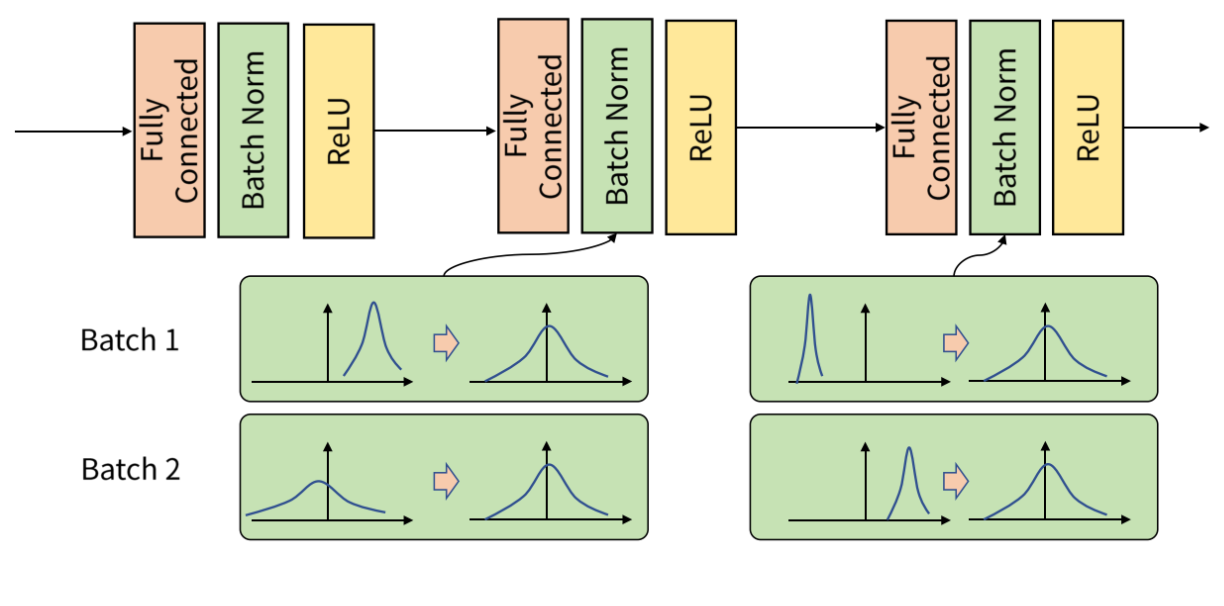

In [ ]:
from IPython.display import Image
Image("bn23.png",width=500)

이것은 모델의 학습 속도를 낮추거나 부정확한 산출값을 제공하거나 학습을 불안정하게 만드는 문제를 발생시킨다. 따라서 우리는 이 문제를 해결하기 위해 배치 정규화를 통해 활성화 함수의 출력값의 분포가 골고루 분포하도록 만들어주어야 한다. 즉, 우리는 각 레이어마다 활성화 출력값이 정규분포에 가깝도록 만들어주어야 한다.[7] <br>

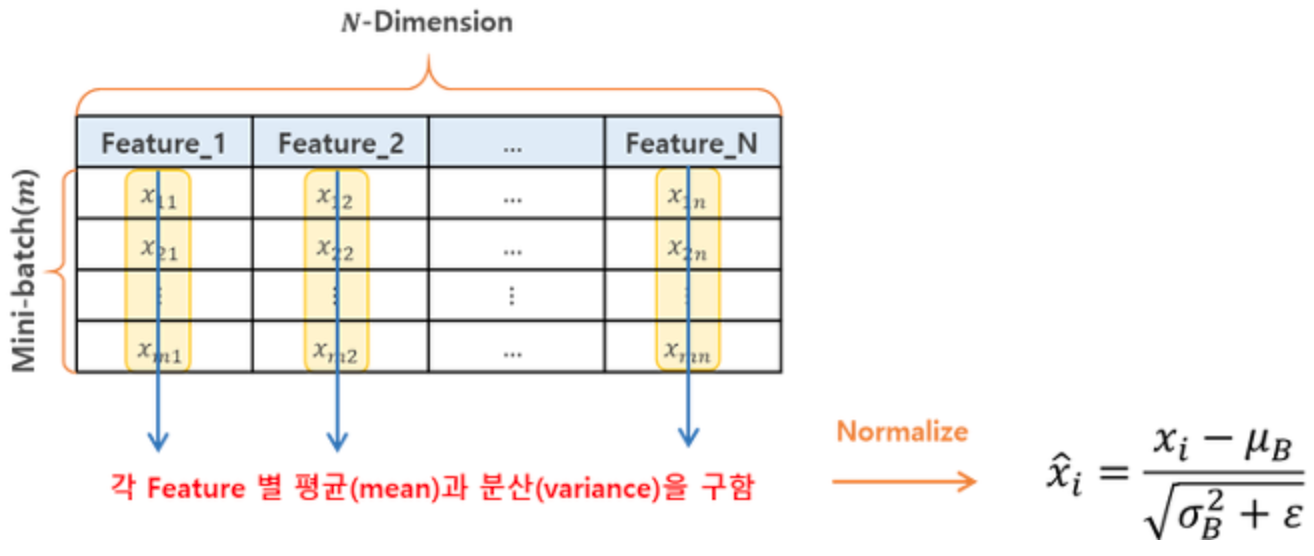

In [ ]:
Image("bn4.png",width=600)

  
  신경망의 깊이가 깊을수록 이전 레이어의 파라미터가 조금만 달라져도 output이 크게 달라질 수 있다는 점(즉 Internal covariate shift 현상이 일어날 수 있다는 점)은 쉽게 받아들일 수 있을 것이다. 하지만 아래 그림처럼 배치 정규화가 각 레이어들 사이에서 일어난다면, 우리는 더 안정적이고 신뢰할만한, 그리고 더 높은 속도로 output을 얻을 수 있을 것이다.

In [3]:
from IPython.display import Image

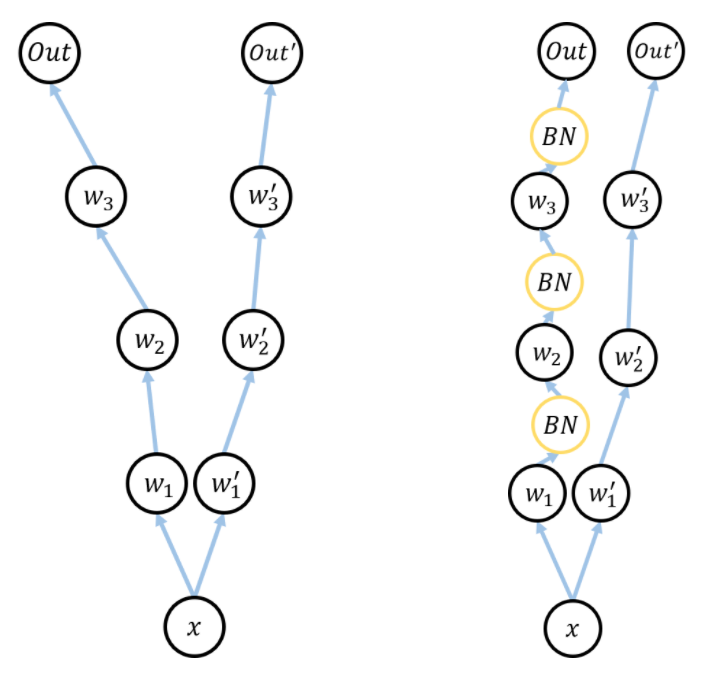

In [ ]:
Image("bn1.png", width =400)

 배치 정규화를 도입할 때 얻는 이점들에 대해 정리하자면, 다음과 같다:  
 
- 학습 효율 ↑<br>
- 가중치 초기화에 의존 정도 ↓<br>
- 과적합 발생 가능성 ↓<br>
- Vanishing Gradient 발생 가능성 ↓<br>

<h3> 2. 어떻게 배치 정규화를 할 것인가? (배치 정규화의 이론과 그 적용)  
  
  위에서 소개한 논문[1]에서 제공하는 배치 정규화의 알고리즘을 살펴보자. 

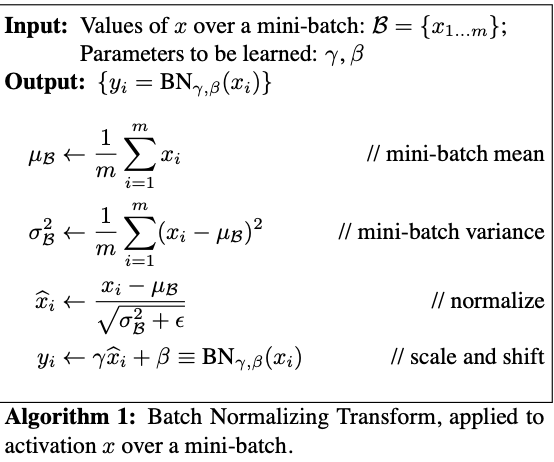

In [ ]:
Image("bn2.png",width=400)

위 알고리즘이 의미하는 바는 "어파인 레이어를 통과한 미니 배치 단위 출력을 표준정규화분포로 정규화하는 작업이다."[6] 우리는 지금부터 cs231n에서 제공한 assignment2의 Batch Normalization에서 요구하는 것을 위 알고리즘을 이용하여 수행할 것이다. 그 구성은 다음과 같다:  
  
  
(1) Batch Normalization Forward  

(2) Batch Normalization Backward  

(3) Alternative Batch Normalization Backward  


  

(1)을 수행하는 것은 쉽다. 하지만 (2), (3)을 수월하게 수행하기 위해서는 (1)에서 잘 준비하는 것이 중요하다. 이것들의 수행을 더 가시적으로 이해해보기 위해 아래 같이 그래프를 그려보았다.

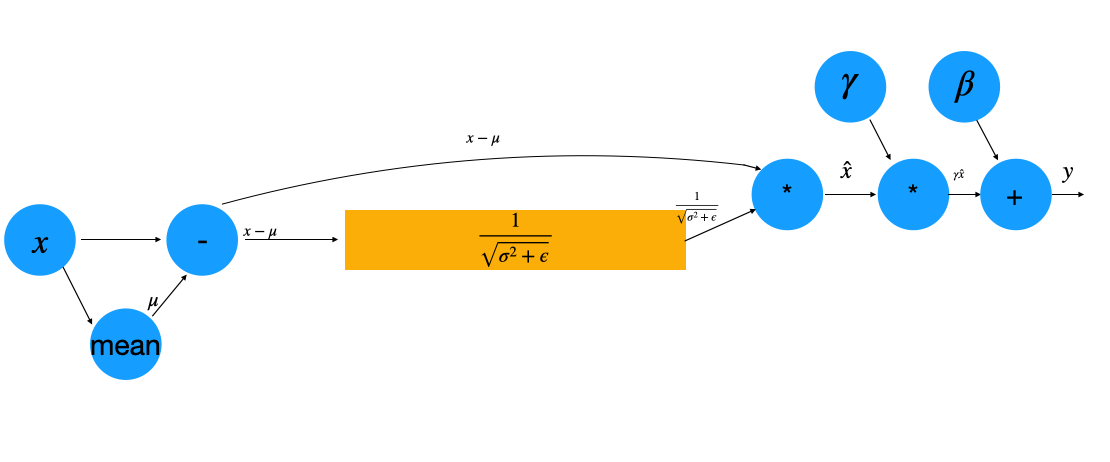

In [ ]:
Image("bn3 2.png",width=800)

위 그래프를 참고하여 Forward를 수행할 때, 주의해야 하는 부분은 주황색 박스 부분이다. Forward만을 수행한다면 이것이 어떻게 작성되는 지는 크게 중요하지 않을 수 있다. 하지만 Backward 를 수월하게 수행하기 위해서는 이것에 대한 상세화가 요구된다. 따라서 나는 모든 개별 연산 과정을 명시해가며 BN Forward 를 수행하고자 한다.   



<h3> 2.1 BN_Forward 

In [11]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Input:

    - x: (N, D) 크기의 입력 데이터
    - gamma:  (D,) 크기의 스케일 매개변수
    - beta:  (D,) 크기의 쉬프트 매개변수
    - bn_param: Dictionary with the following keys:

      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability

      - momentum: Constant for running mean / variance.

      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:

    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """

    mode = bn_param["mode"] # bn_param = {'mode': 'train'}
    eps = bn_param.get("eps", 1e-5) # .get은 딕셔너리 값 가져오기
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape # 입력값 shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    #각각의 timestep 마다 우리는 모멘텀 패러미터를 기반으로 exponential decay를 사용하여 평균과
    # 분산의 running averages를 업데이트 한다.
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":
        #######################################################################

        mu = np.mean(x, axis = 0) #mu_b = x의 평균 (D,)
        x_mu = x-mu # x - mu (1) 

        #variance^2

        var_1 = (x_mu)**2 #N,D
        var_2 = 1/float(N)*np.sum(var_1,axis=0) # 분산 만들기 끝 (D,)

        # x_hat (주황색 박스 부분 상세화)

        x_hat2 = np.sqrt(var_2+eps) # D,
        x_hat3 = 1/x_hat2 # (2) 1/sqrt(var^2 +eps), eps: 수치적 안정성의 상수, (D, )
        
        x_hat = x_mu*x_hat3 # (1)*(2): 정규화 (N,D)
        
        y = gamma*x_hat + beta # scale & shift. (N,D)
        out = y #N, D

        #running_mean,var 업데이트 하기

        running_mean = momentum * running_mean + (1-momentum)*mu
        running_var = momentum*running_var+(1-momentum)*var_2

        cache = (mu, x_mu, var_1, var_2, x_hat2, x_hat3, x_hat, gamma, beta) # backward 시 변수들 사용하기 위해

        #######################################################################
    elif mode == "test":
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        x_hat = (x-running_mean) / np.sqrt(running_var+eps) # 정규화 데이터
        y = gamma*x_hat + beta # 스칼라&쉬프트
        out = y
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache

배치 정규화를 통해 우리는 아래 결과에서 std가 대략 1에 수렴하는 것을 볼 수 있다. 또한 우리는 $\gamma, \beta$값을 점점 크게 바꿈으로써 mean, std도 점점 커지는 것을 확인할 수 있다. 

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)
print('=====(training-time)======\n\n')
print('[1] 배치 정규화 이전의 mean, std:\n')
print_mean_std(a,axis=0)
print(' \n==>표준정규분포화가 되어있지 않다\n\n')

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('[2] (gamma=1, beta=0)인 경우에, 배치 정규화 이후의 mean, std\n')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)
print('\n==> 표준정규분포화가 된 것을 확인할 수 있다.\n\n')

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('[3] (gamma=', gamma, ', beta=', beta, ')인 경우에, 배치 정규화 이후의 mean, std\n')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

=====(training-time)======


[1] 배치 정규화 이전의 mean, std:

  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

 
==>표준정규분포화가 되어있지 않다


[2] (gamma=1, beta=0)인 경우에, 배치 정규화 이후의 mean, std

  means:  [5.99520433e-17 6.93889390e-17 8.32667268e-19]
  stds:   [0.99999999 1.         1.        ]


==> 표준정규분포화가 된 것을 확인할 수 있다.


[3] (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )인 경우에, 배치 정규화 이후의 mean, std

  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [ ]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)


for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('======(test-time)======\n\n 배치 정규화 이후의 mean, std  값\n:')
print_mean_std(a_norm,axis=0)
print('\n ==> std가 1에 수렴. 즉, 어파인 레이어는 배치 정규화를 통해 표준정규분포화가 되었다.')

======(test-time)======

 배치 정규화 이후의 mean, std  값
:
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531428 1.01238373 0.97819988]


 ==> std가 1에 수렴. 즉, 어파인 레이어는 배치 정규화를 통해 표준정규분포화가 되었다.


2.2 BN_Backward  
  
  Backward 과정의 수학적 이해는 다소 도전적인 계산을 요구한다. 나는 이것의 분명한 수학적 이해를 [2]에서 얻을 수 있기를 바란다. 나는 이것을 수행하는 데 있어서 [2], [3] 에서 많은 도움을 받았다. [2]에서는 Backward 계산 시 요구되는 명료하고 상세한 수학적 이해를 얻을 수 있고, [3]을 참고한다면 - 기본적인 Backpropagation 이해[8]를 갖고 있는 경우에 - 그래프를 이용하여 보다 더 효율적으로 Backward 과정을 수행할 수 있다. 필자는 처음에 [3]과 같은 방식으로 접근을 하였고, 그러한 탓에 아래 코드를 완성하기까지 [3]으로부터 큰 도움을 받았다. 이것을 본격적으로 수행하기 이전에, 아래 그림을 참고하여 cs231n 4강 Backpropagation 파트에서 정리된 add gate, mul gate를 상기해보자.  


<h4> 2.2.1 예비작업 1<br><br>

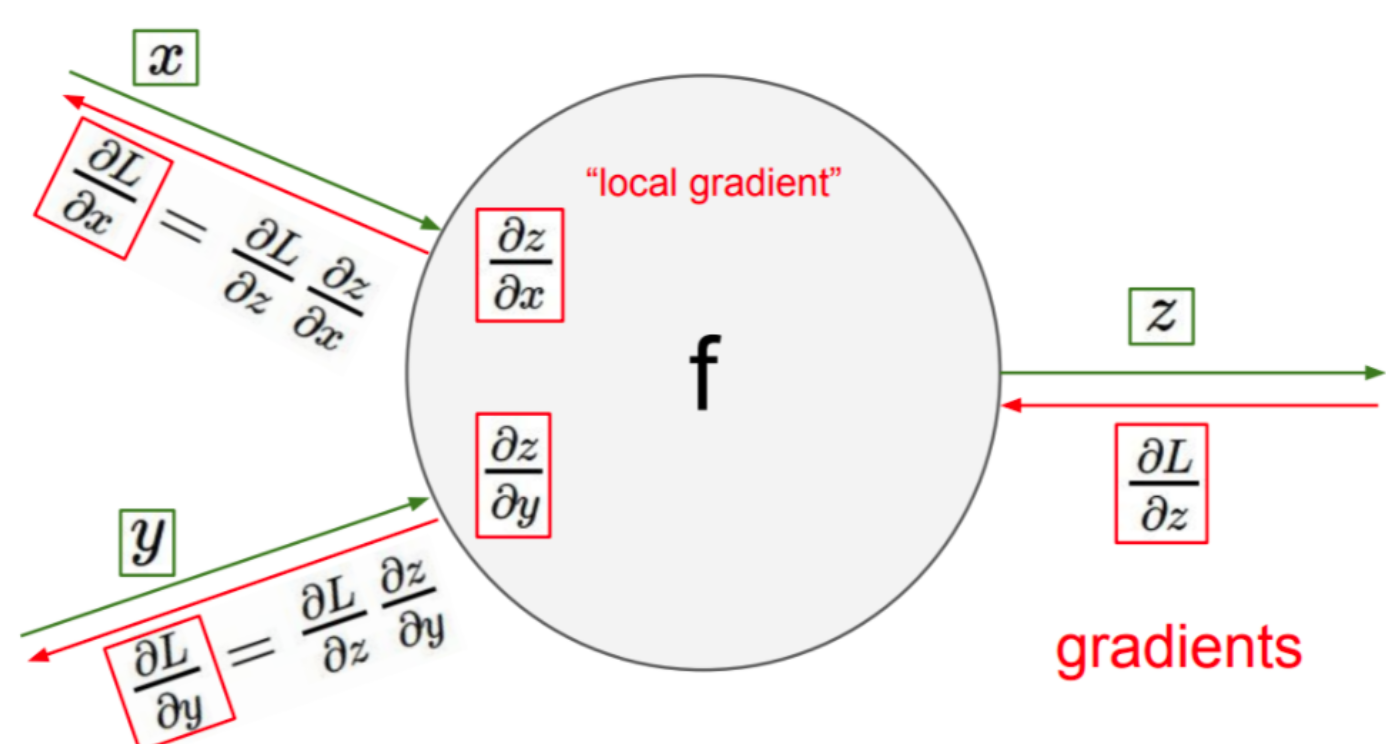

In [ ]:
Image("bn20.png",width=600)

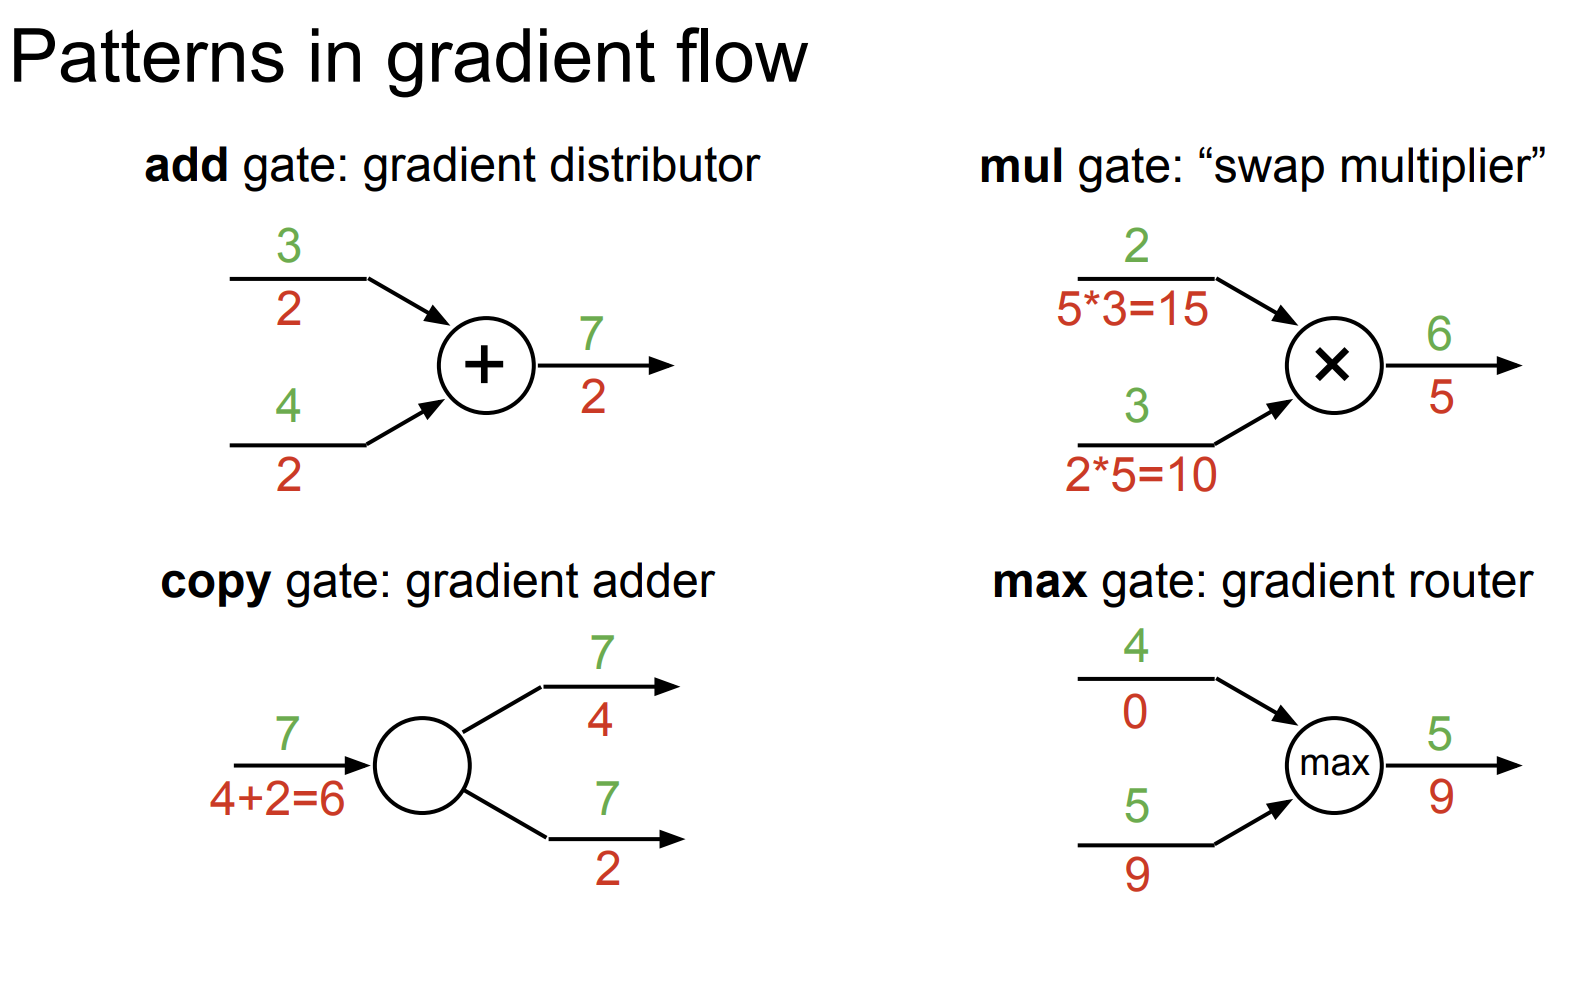

In [ ]:
Image("bn9.png", width=600)

<h5> 우리가 아래서 사용할 gate는 위 그림 중 2 가지 뿐이다: add, mul.  
  
   (1) add 게이트는 (빨간색으로 표시된 숫자) output의 미분값이 2일 때, 그 이전 단계의 미분값에 그 수를 "분배"해준다.  
     
다른 한편,   
  
  (2) mul 게이트는 (빨간색으로 표시된 숫자) output의 미분값이 5이고, 입력값 A가 2, 입력값 B가 3일 때, A의 미분값은 5*(B의 미분값=3)이고, B의 미분값은 5*(A의 미분값=2)이다. 즉, mul 게이트는 각 입력값의 미분값을 구할 시, output의 미분값에 그것들의 입력값을 "switch (swap)"해서 곱해준다. 

 <h4> 2.2.2 예비 작업2<br>
 <h5>우리는 backward 를 계산하는 동안 다음의 계산을 자주 사용한다. 따라서 이것에 대한 명료한 이해는 중요하다:

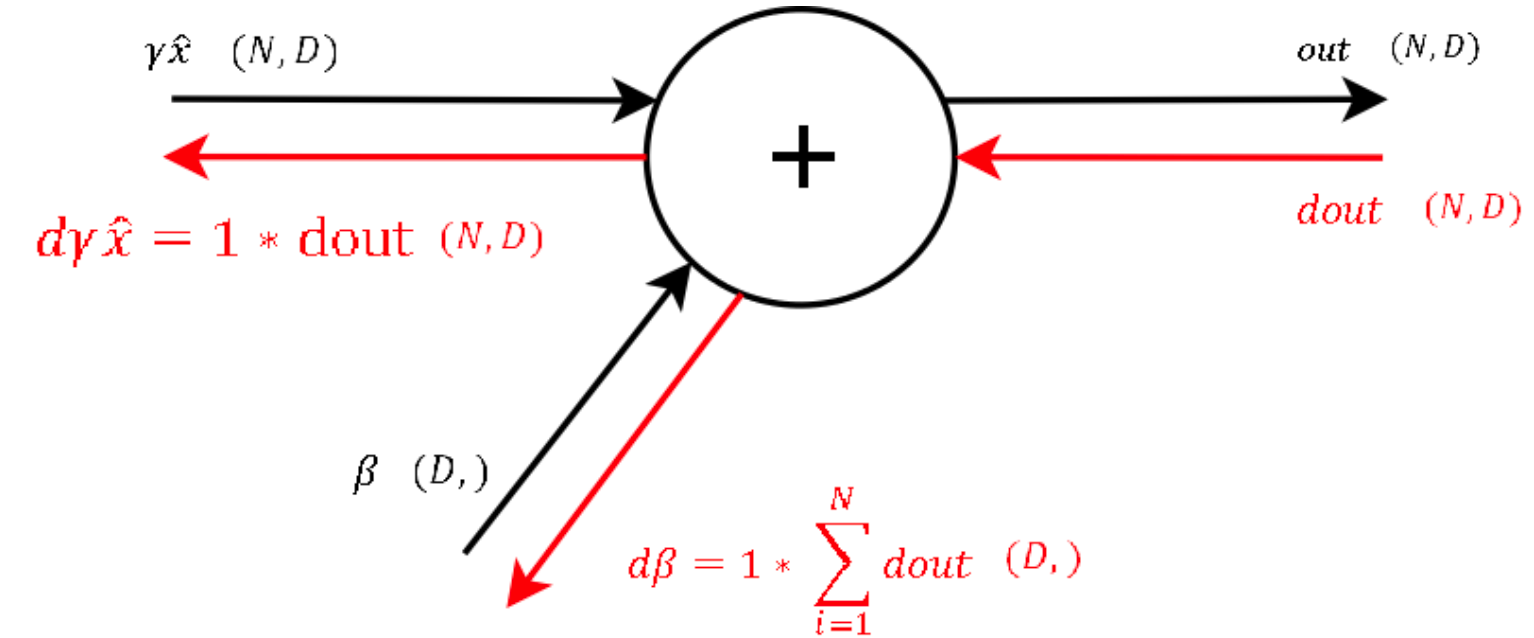

In [ ]:
Image("bn5.png",width=600)

$f=x+y$인 경우에, $\frac{df}{dx}$ (이하 이것은 간단히 $dx$라고 칭한다) $=1$이고, $\frac{df}{dy}=1$이라는 점을 기억해보자. 여기서 Backpropagation(역전파) 개념을 도입해보자. 마지막으로, 위해서 다시 보았듯이, add gate는 분배기 역할을 한다는 점을 기억해보자.  

그러면, 우리가 풀 문제의 일부분에 이것을 적용해보자면, $y = \gamma*\hat x + \beta$에 대하여,  
  
  (1) $\frac{dout}{d \gamma \hat x} = 1*dout(N,D)$이고,  
    
(2) $d \beta = 1*\sum_{i=1}^N dout$ (D, ) 이다. (아래 그래프 참고)  

  
  (2)의 메커니즘을 가시화 하자면 아래 그림과 같다. (N,D)를 (5,4)라고 가정할 때, dout 행렬은 아래와 같이 벡터화된다.

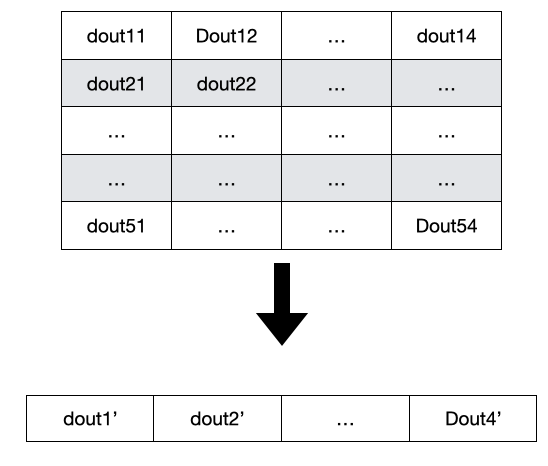

In [ ]:
Image("bn77.png",width=400)

  
  아래서 수행할 Backward 계산은 다음의 그래프와 같이 진행된다. Forward 경우에는 x에서 y로 향했다면, Backward 는 그 반대이다. 즉, y에서 x로 향한다.

<h4> 2.2.3 BN_backward 그래프  


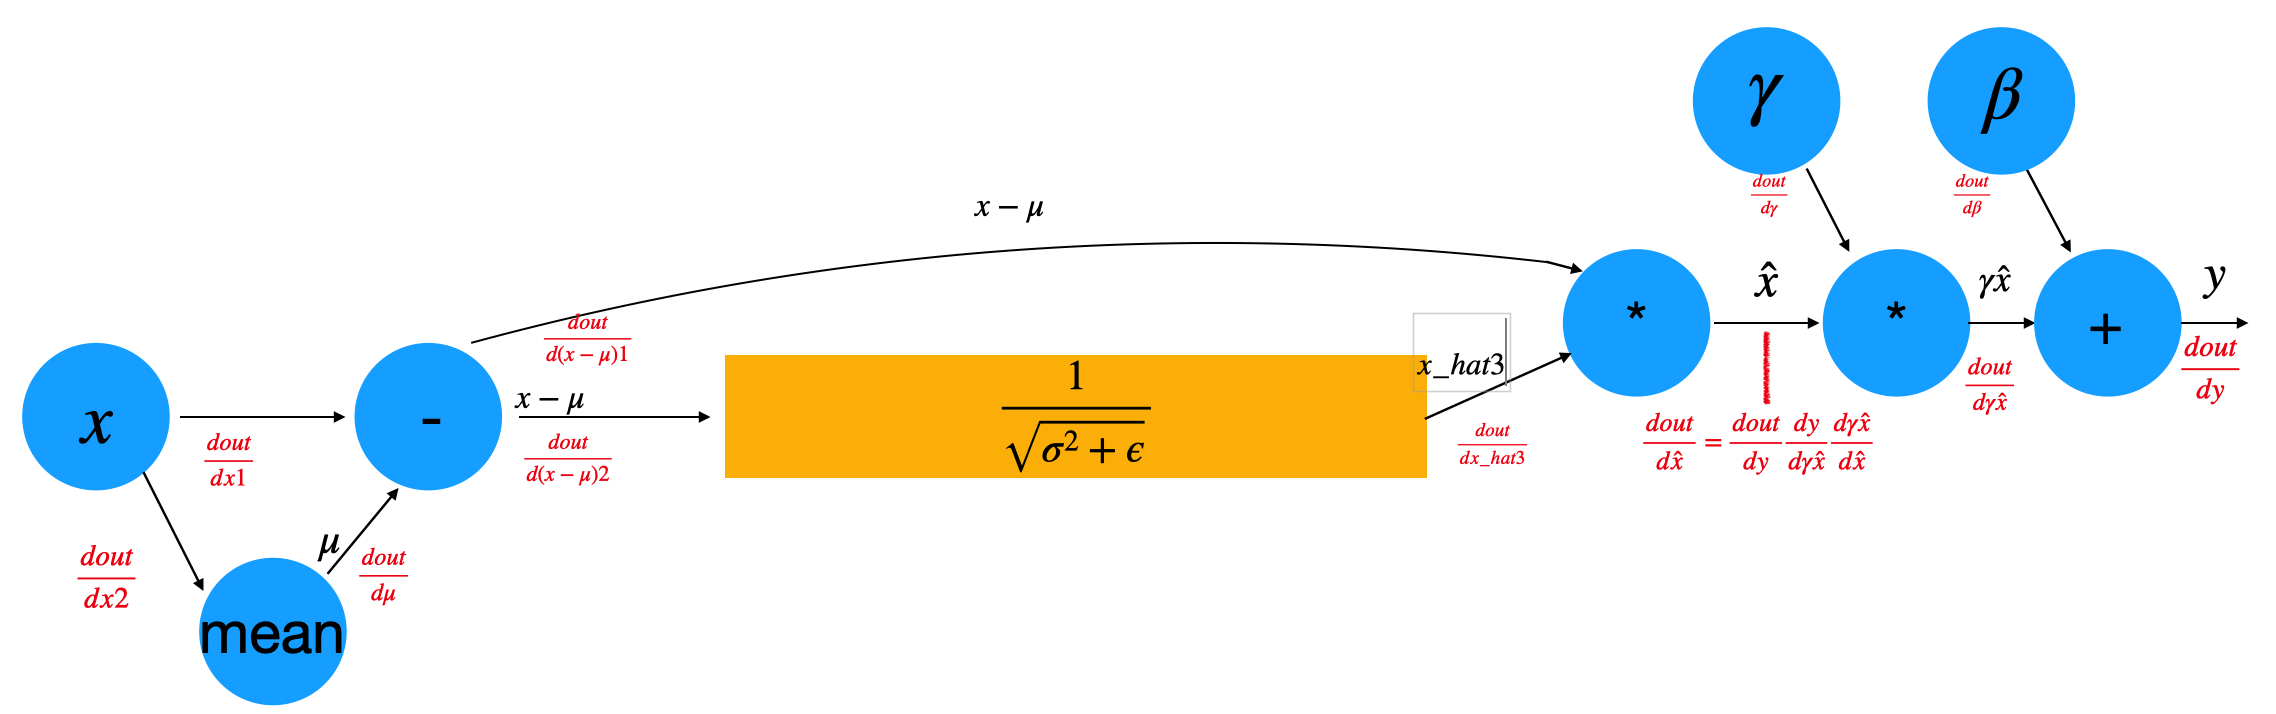

In [5]:
Image("bn25.png", width = 1000)

<h5> 주황색 박스 안의 상세화를 위해,  아래 그림을 참고해보자. Backprop을 위해 우리는 하나의 연산 $\frac{1}{\sigma^2+\epsilon}$을 각각의 연산으로 쪼개야 한다. 각 연산의 수행 시마다 행렬 및 벡터의 크기 변환에도 주목해야 한다.

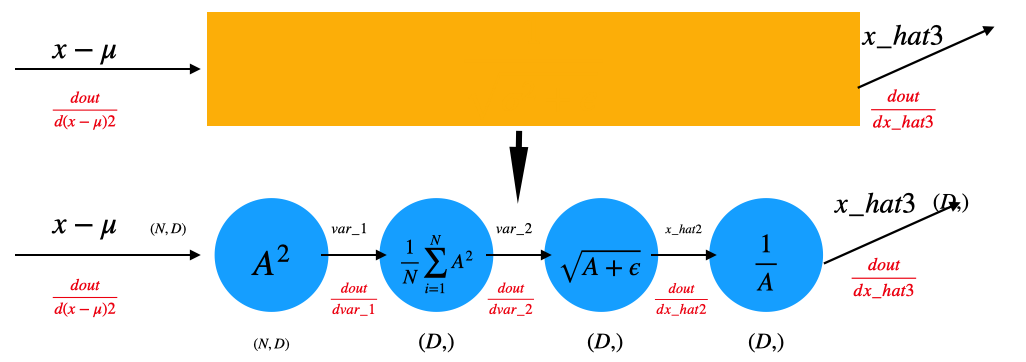

In [ ]:
Image("bn13.png",width=800)

<h4> 2.2.4 BN_Backward 수행

In [34]:

import numpy as np
def batchnorm_backward(dout, cache): # dout = np.random.randn(N, D)
    """


    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx:  (N, D) 크기의 x에 대한 그래디언트
    - dgamma:  (D,) 크기를 가진 감마에 대한 그래디언트
    - dbeta: (D,) 크기를 가진 베타에 대한 그래디언트
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    N, D = dout.shape

    mu, x_mu, var_1, var_2, x_hat2, x_hat3, x_hat, gamma, beta = cache

    dbeta = 1*np.sum(dout, axis = 0)
    dgamma_x_hat = 1* dout

    dgamma = np.sum(dgamma_x_hat * x_hat,axis=0)
    dx_hat = dgamma_x_hat*gamma
    
    

    # (x-mu)1 input

    dx_mu_1 = dx_hat*x_hat3 # By mul gate, switch
    
    #(x-mu)2 input (orange box)

    #우리는 dx_mu_2를 구하고자 한다. 그 과정은 아래와 같다:
    dx_hat3 = np.sum(x_mu*dx_hat, axis=0) # D, 참고:x_hat2 = np.sqrt(var_2+eps), x_hat3 = 1/x_hat2 
    dx_hat2 = dx_hat3*(-1/(x_hat2**2)) # D,
    dvar_2 = (1/2)*(1/(x_hat3)) * dx_hat2 # D,
    dvar_1 = (1/float(N))*np.ones((N,D))*dvar_2 # N,D // 아래 주석 그림 1 참고.
    dx_mu_2 = 2*x_mu*dvar_1 # N,D

    # dx = dx1 + dx2 임을 주목하라.

    #dx1 구하기
    dx1 = 1*(dx_mu_1+dx_mu_2) # N,D

    #dx2 구하기
    dmu = -1*np.sum(dx1, axis=0) # D,
    dx2 = 1/float(N) * np.ones((N,D))*dmu #N,D

    dx = dx1 + dx2 #N,D
    ###########################################################################

    return dx, dgamma, dbeta


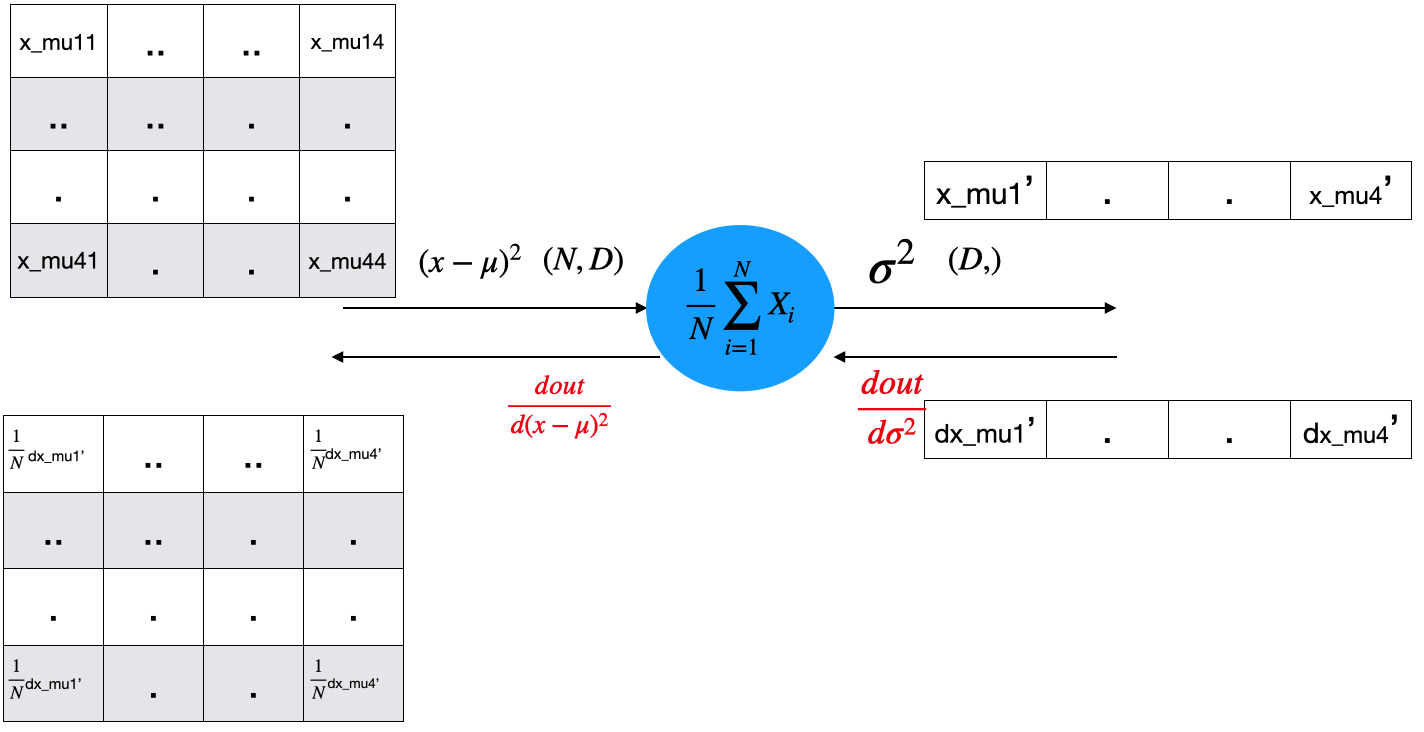

In [ ]:
Image("bn22.png",width=600)

In [35]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.0
dgamma error:  7.417225040694815e-13
dbeta error:  2.379446949959628e-12


<h4>2.3 Alternatives

위 코드로 짜면 dx error가 1.0이 나오는데, 이것은 문제에서 요구한 error 값이 아닌 것 같다. 따라서 [1]에서 제공된 식을 이용하여 다음 같이 수정해본다:

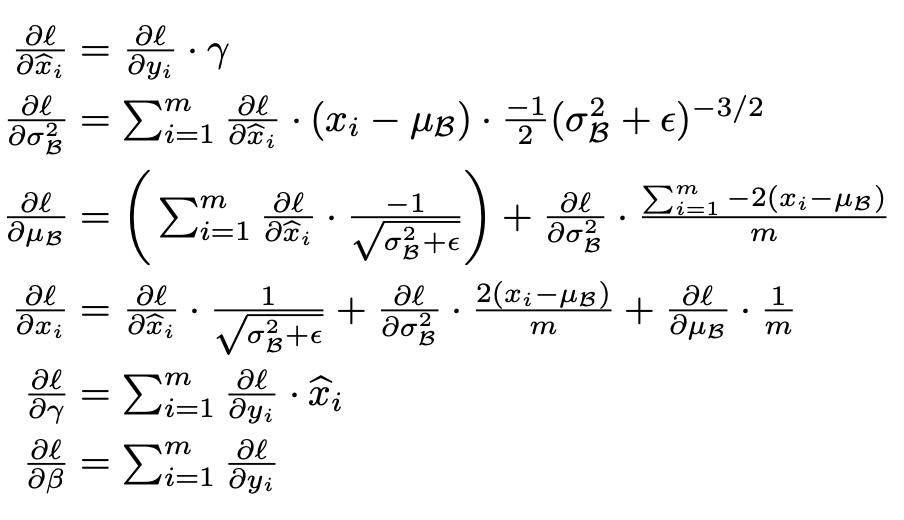

In [ ]:
Image("bn21.png",width=600)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1]에서 제공된 식

In [31]:
def batchnorm_backward(dout, cache):
    
    dx, dgamma, dbeta = None, None, None
 
    ###########################################################################
    N, D = dout.shape
    mu, x_mu, var_1, var_2, x_hat2, x_hat3, x_hat, gamma, beta = cache

    dbeta = 1*np.sum(dout, axis = 0)
    dgamma_x_hat = 1* dout

    dgamma = np.sum(dgamma_x_hat * x_hat,axis=0)
    dx_hat = dgamma_x_hat*gamma

    #우리는 dx_mu_2를 구하고자 한다. 그 과정은 아래와 같다:
    dx_hat3 = np.sum(dx_hat*x_mu, axis=0) # D,
    dx_hat2 = dx_hat3*(-1/(x_hat**2)) # D,
    dvar_2 = (1/2)*(1/(np.sqrt(x_hat2))) * dx_hat2 # D,

    dx = dx_hat*var_2+dvar_2*2*x_mu/N+(1/N)*((np.sum(dx_hat3*x_mu, axis=0)*(-0.5)*(x_hat3**(-3))))
    ###########################################################################

    return dx, dgamma, dbeta

In [ ]:
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))


dx error:  1.0
dgamma error:  7.417225040694815e-13
dbeta error:  2.379446949959628e-12


## Reference  
<h5> [1] Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).<br>
[2]http://cthorey.github.io./backpropagation/  
[3]https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html<br>
[4] https://gomguard.tistory.com/186<br>
[5]https://github.com/musicjae/Seminar/blob/master/summer_2020/0721_Training%20Neural%20Net__jjy.pdf<br>
[6]김남기, 전준철, 지명근. (2018). 배치 정규화와 CNN을 이용한 개선된 영상분류 방법. 인터넷정보학회논문지, 19(3), 35-42.

Namgi Kim, Junchul Chun, Myunggeun Ji. (2018). An Improved Image Classification Using Batch Normalization and CNN. Journal of Internet Computing and Services (JICS), 19(3), 35-42.<br>
[7] https://excelsior-cjh.tistory.com/178<br>
[8] http://intelligence.korea.ac.kr/seminar/2020/04/06/SpringSeminar.html 의 Backpropagation을 참고하면, Backpropagation에 대한 기본적인 수학적 이해를 얻을 수 있다.
[9]https://gaussian37.github.io/dl-concept-batchnorm/ 배치 정규화 이론에 대한 직관적인 이해를 얻을 수 있는 좋은 포스팅이다.